# MCT4052 Workshop 6c: Displaying 2D Decision Boundaries for Classification

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

This is example shows how to display 2D decision boundary for classification tasks. On top of the decision boundary we display a scatter plot of the features with color-coded classes. This is possible when displaying only the first two coponents after dimensionality reduction and displaying/keeping only the first two components, or when working only with two features.

In [1]:
#import packages
import numpy as np
import pandas as pd
import librosa, librosa.display
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as ms
#ms.use("seaborn-v0_8")
import os

In [2]:
#loading the metadata in a pandas data structure and displaying
metadata = pd.read_csv('./data/examples4/meta.csv')

#finding unique labels (i.e. how many different classes in the dataset)
classes = list(metadata.label.unique()) # finding unique elements in the 'label' column
print('There are',len(classes),'different classes:',classes)

sr = 22050

def extract_features(filename, sr):
    
    signal, dummy = librosa.load(filename, sr=sr, mono=True)
    
    output = [
        np.mean(librosa.feature.zero_crossing_rate(y=signal)),
        np.mean(librosa.feature.spectral_centroid(y=signal)),
        np.mean(librosa.feature.spectral_contrast(y=signal)), 
        np.mean(librosa.feature.spectral_flatness(y=signal)),
        np.mean(librosa.feature.spectral_bandwidth(y=signal)),
        np.mean(librosa.feature.spectral_rolloff(y=signal)),
        np.mean(librosa.feature.rms(y=signal))
    ]
    
    return output

print('number of files in database',len(metadata.index))
features = np.zeros((len(metadata.index),7)) 
labels = np.zeros((len(metadata.index)))

for i, row in metadata.iterrows():
    features[i,:] = extract_features('./data/examples4/'+row['filename'], sr=sr)
    labels[i] = (classes.index(row['label']))

print('Done!')

There are 5 different classes: ['cello', 'guitar', 'clarinet', 'flute', 'harmonica']
number of files in database 60
Done!


In [3]:
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.2, random_state=7)

#learning the scaling transformation from the train data and applying it to both train and test set.

#creating scaling object
scaler = sklearn.preprocessing.StandardScaler()

#learning scaling from train set
scaler.fit(feat_train)

#applying scaling to both train and test set
feat_train = scaler.transform(feat_train)
feat_test = scaler.transform(feat_test)

#Creating an instance of the LDA object, which is an object capable of learning and applying LDA from/to data.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#here we keep only two components
lda = LinearDiscriminantAnalysis(n_components=2)


#This will learn LDA projection from train data
lda.fit(feat_train,lab_train)

#Now we project the data using LDA
projected_features_train = lda.transform(feat_train)
projected_features_test = lda.transform(feat_test)

#this is only for scatter plot purposes
projected_features = lda.transform(scaler.transform(features))

#Creating an instance of a SVM classifier
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=2.0)

#training the model
svm.fit(projected_features_train, lab_train)

#applying the the model on the test data (features)
lab_predict = svm.predict(projected_features_test)


#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

Number of mislabeled samples 3 out of 12
Accuracy: 0.75


### 1. Computing and displaying decision boundaries and scatter plot

Classes: ['cello', 'guitar', 'clarinet', 'flute', 'harmonica']
Integer Label: [0, 1, 2, 3, 4]


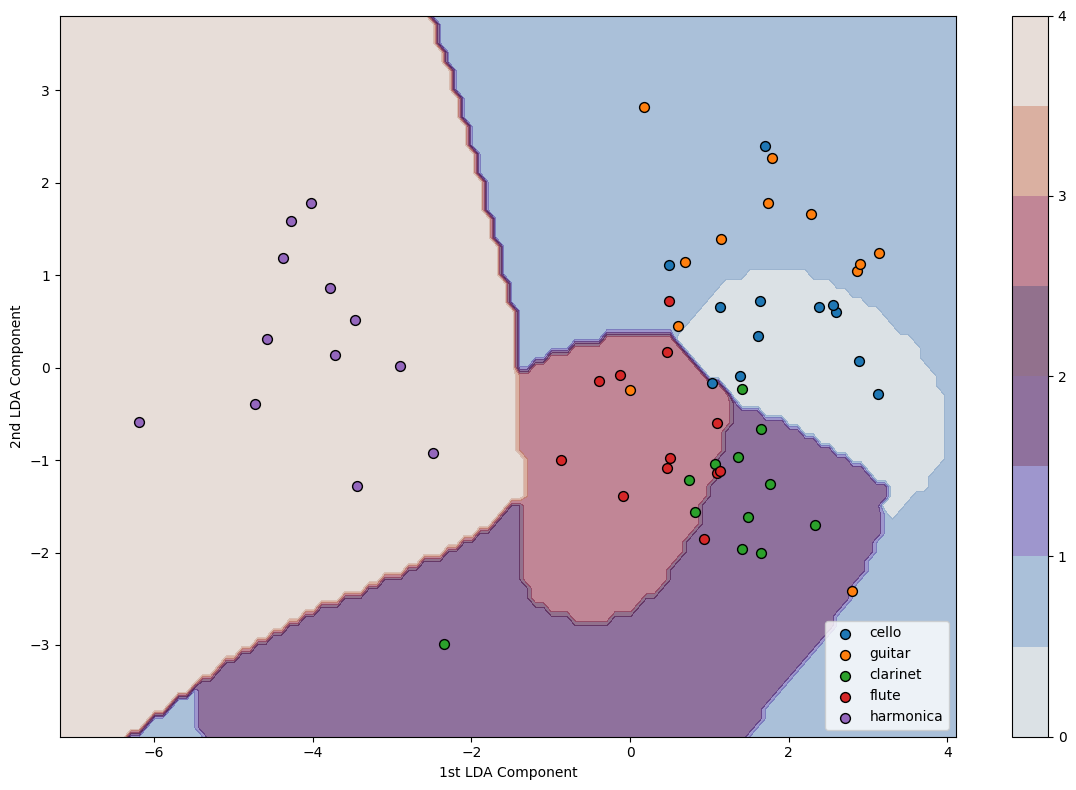

In [4]:
#displaying class anmes and associated integer
print('Classes:',classes)
print('Integer Label:',list(range(0,len(classes))))


# Plotting decision boundaries (the using only the first two projected features)

#the next 5 lines prepare the data necessary to plot the boundaries
x_min, x_max = projected_features[:, 0].min() - 1, projected_features[:, 0].max() + 1
y_min, y_max = projected_features[:, 1].min() - 1, projected_features[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]) #this is our trained classifier, and will work only if we keep 2 components after LDA, otherwise modifications are needed (add dummy data on other dimensions)
Z = Z.reshape(xx.shape)

#plotting
plt.figure(figsize=(12, 8))
cs = plt.contourf(xx, yy, Z, alpha=0.6, cmap='twilight') #this plots the boundaries, for more colormap https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
plt.colorbar(ticks=np.linspace(0,4,5)) #this must be tned to the number of classes
for lab_val, lab_name in zip(range(0,len(classes)),classes):
    plt.scatter(projected_features[labels==lab_val, 0],
                  projected_features[labels==lab_val, 1],
                  label=lab_name, s=50, edgecolor='k')
plt.xlabel('1st LDA Component')
plt.ylabel('2nd LDA Component')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()